In [34]:
!pip install optuna
!pip install xgboost
!pip install catboost

In [35]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
import joblib
import warnings
warnings.filterwarnings('ignore')

## **Correlation Analysis**

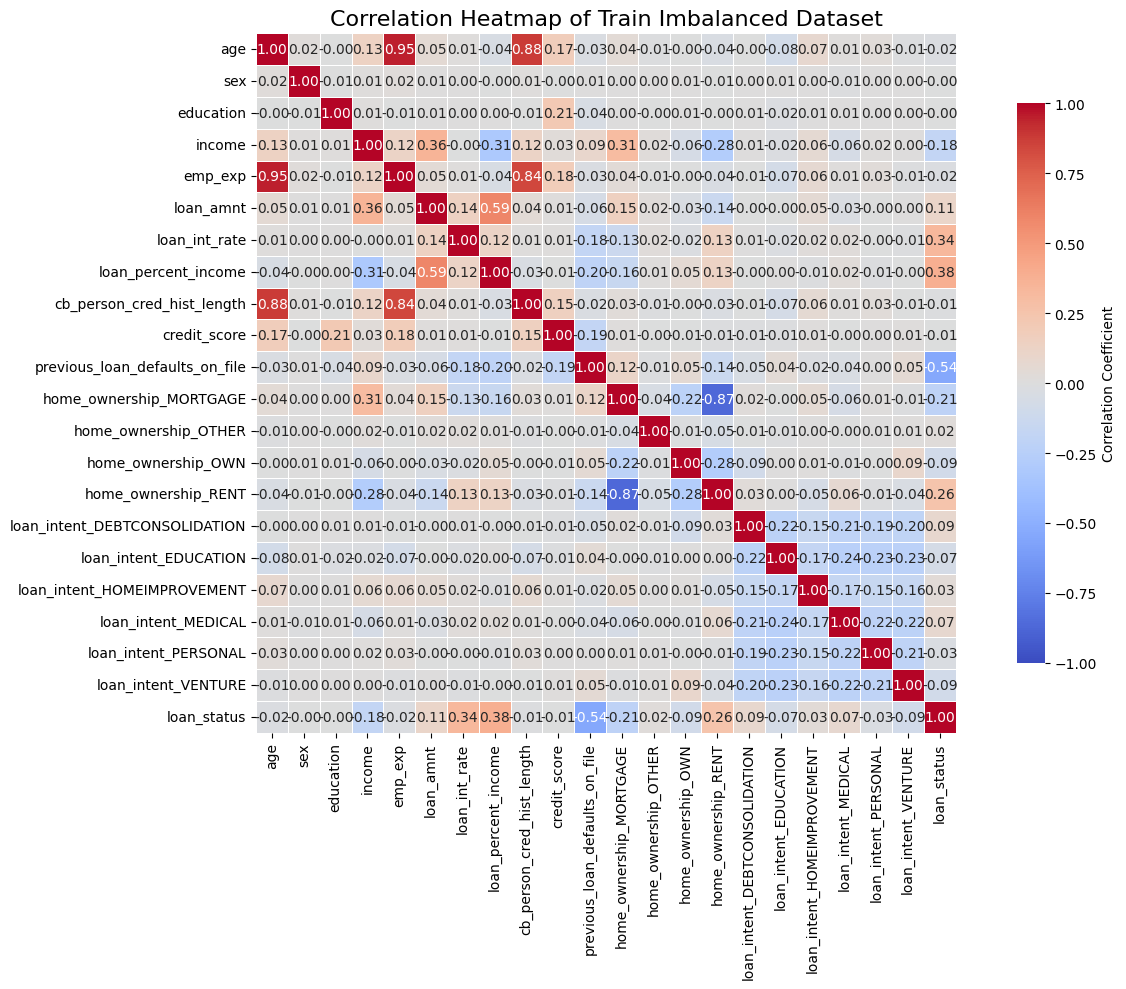

In [ ]:
# Compute correlation matrix
corr_matrix = train_imbalanced.corr()

# Set figure size
plt.figure(figsize=(14, 10))

# Create heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})

# Set title
plt.title('Correlation Heatmap of Train Imbalanced Dataset', fontsize=16)

# Show the heatmap
plt.tight_layout()
plt.show()

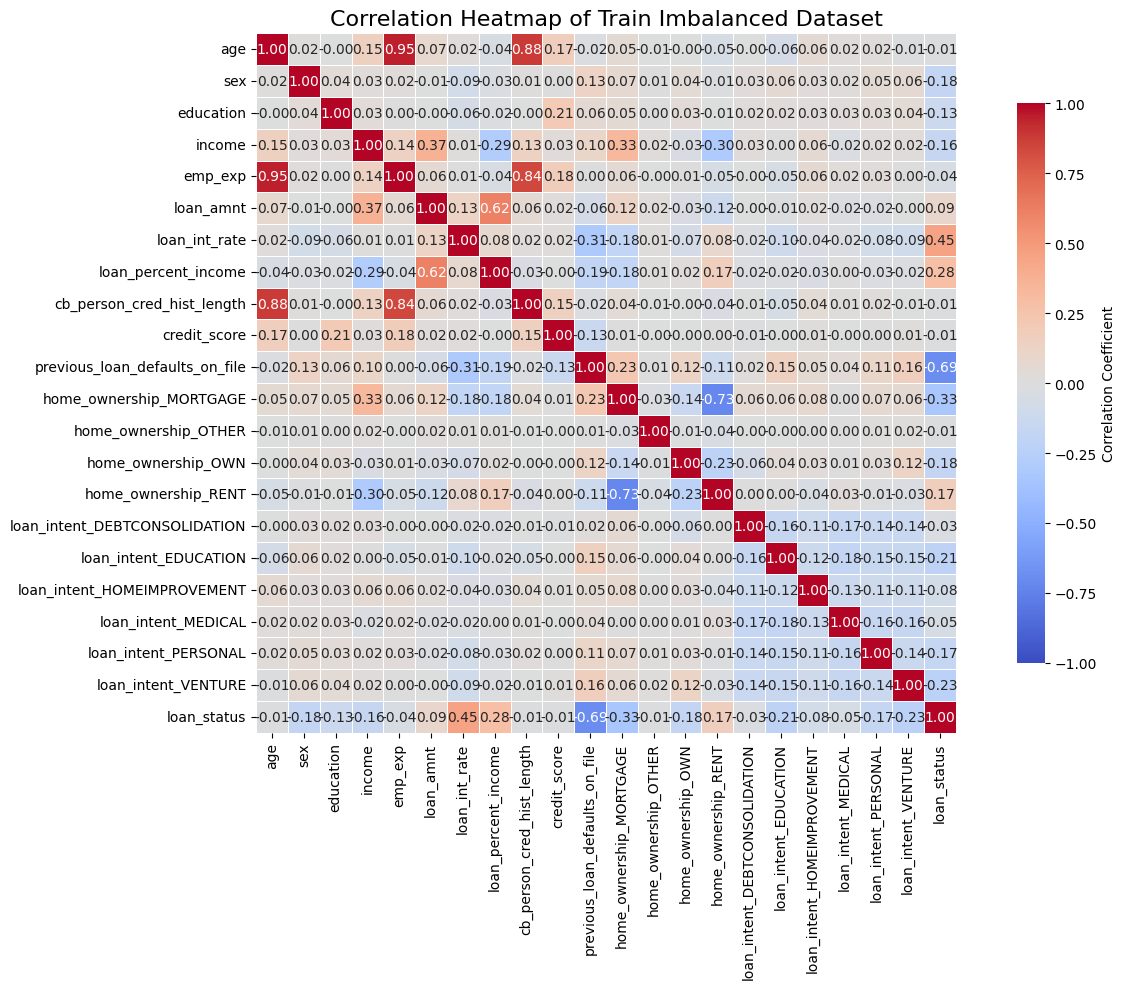

In [ ]:
# Compute correlation matrix
corr_matrix = train_oversampled.corr()

# Set figure size
plt.figure(figsize=(14, 10))

# Create heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})

# Set title
plt.title('Correlation Heatmap of Train Imbalanced Dataset', fontsize=16)

# Show the heatmap
plt.tight_layout()
plt.show()

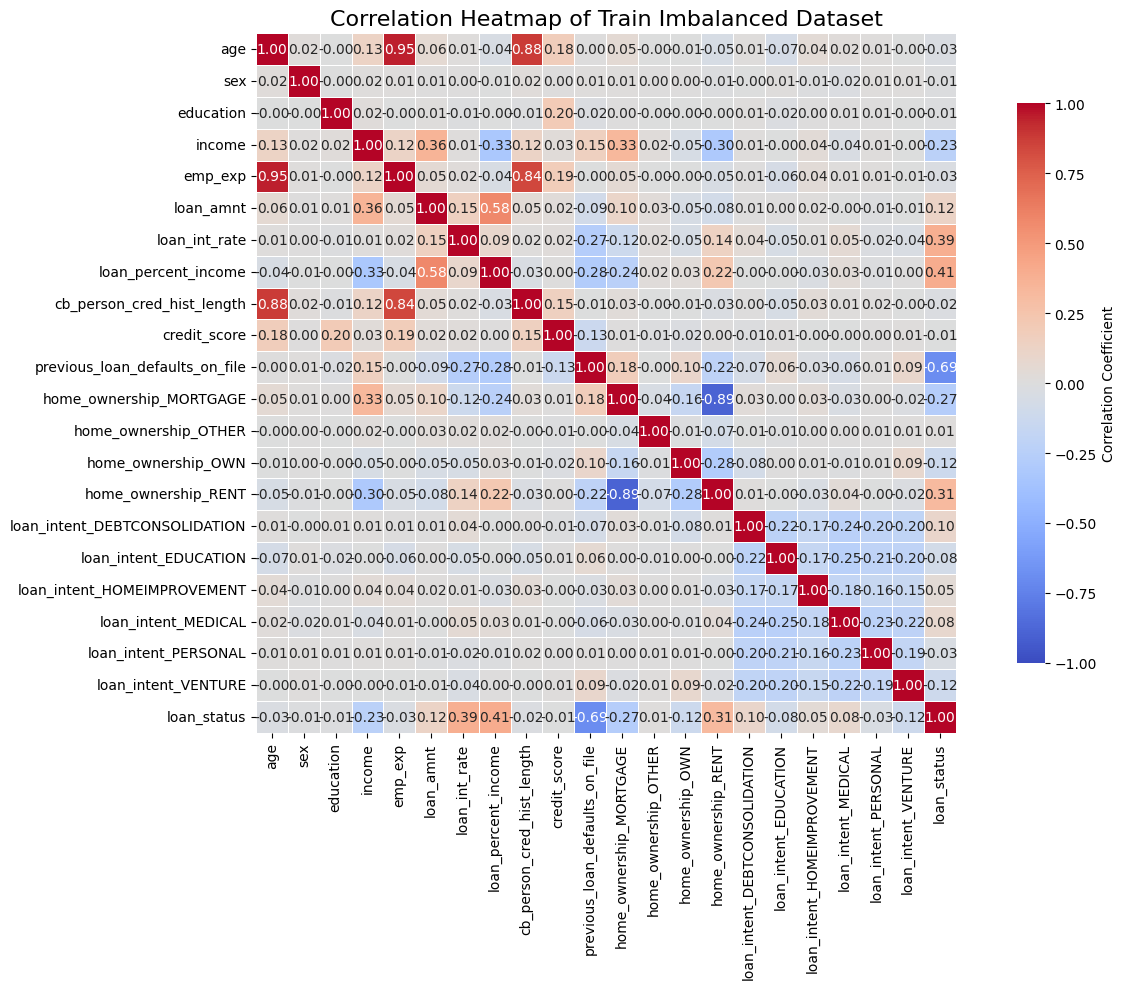

In [ ]:
# Compute correlation matrix
corr_matrix = train_undersampled.corr()

# Set figure size
plt.figure(figsize=(14, 10))

# Create heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})

# Set title
plt.title('Correlation Heatmap of Train Imbalanced Dataset', fontsize=16)

# Show the heatmap
plt.tight_layout()
plt.show()

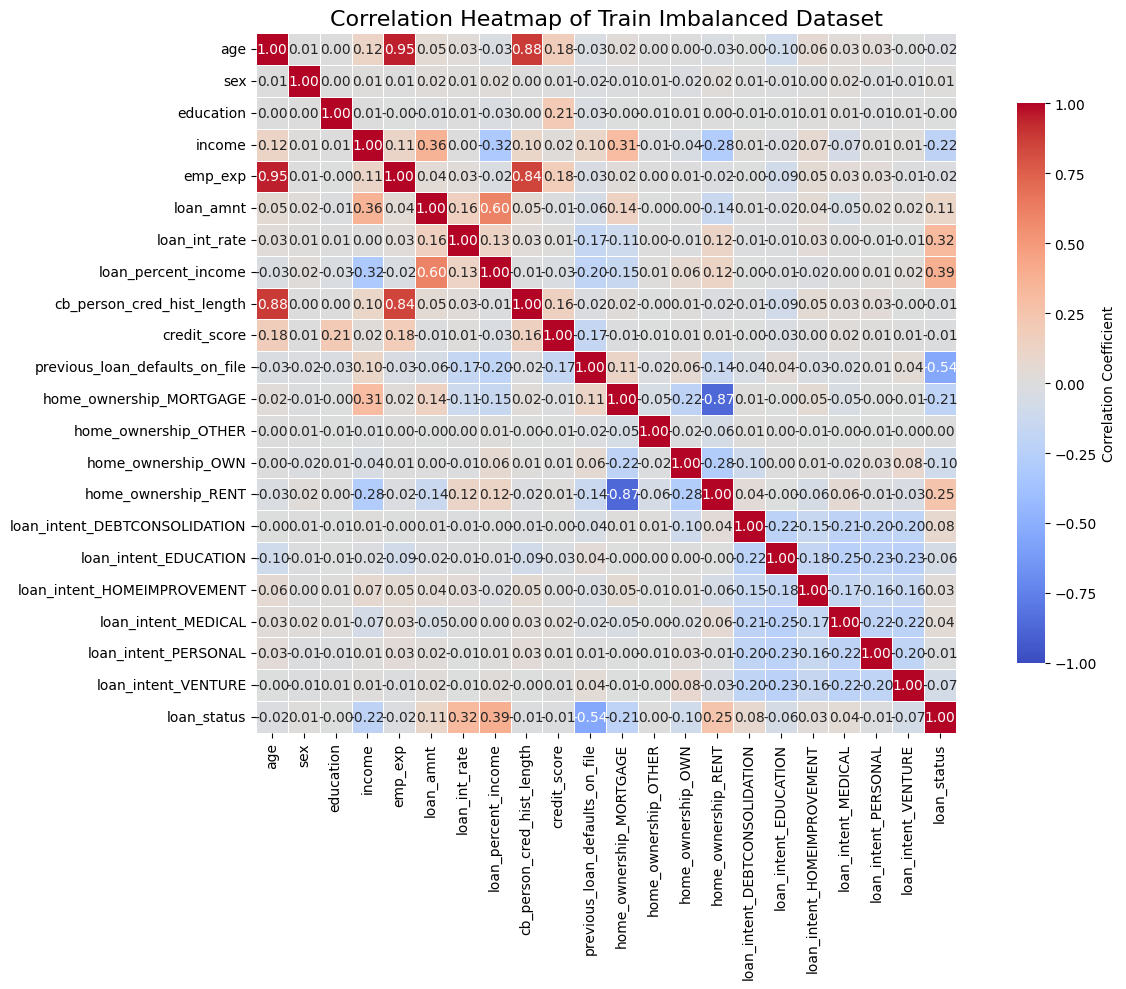

In [ ]:
# Compute correlation matrix
corr_matrix = test_set.corr()

# Set figure size
plt.figure(figsize=(14, 10))

# Create heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})

# Set title
plt.title('Correlation Heatmap of Train Imbalanced Dataset', fontsize=16)

# Show the heatmap
plt.tight_layout()
plt.show()

# **DATA PREPROCESSING**

In [36]:
# Load train sets
train_imbalanced = pd.read_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/train_set_imbalanced.csv')
train_oversampled = pd.read_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/train_set_oversampled.csv')
train_undersampled = pd.read_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/train_set_undersampled.csv')

## **Data Pipeline**

In [37]:
# Features to scale
numeric_features = [
    'age',
    'income',
    'education',
    'emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score'
]

# All features except target
all_features = [
    'age', 'sex', 'education', 'income', 'emp_exp', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    'credit_score', 'previous_loan_defaults_on_file',
    'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
    'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'
]

# Features to passthrough
passthrough_features = list(set(all_features) - set(numeric_features))

preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), numeric_features),
        ('pass', 'passthrough', passthrough_features)
    ]
)

# Separate X and y
X_train_imbal = train_imbalanced.drop(columns='loan_status')
y_train_imbal = train_imbalanced['loan_status']

X_train_over = train_oversampled.drop(columns='loan_status')
y_train_over = train_oversampled['loan_status']

X_train_under = train_undersampled.drop(columns='loan_status')
y_train_under = train_undersampled['loan_status']

X_test = test_set.drop(columns='loan_status')
y_test = test_set['loan_status']

# Preprocessing pipelines (fit only on train sets)
pipeline_imbal = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline_over = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline_under = Pipeline(steps=[('preprocessor', preprocessor)])


# Transform (fit_transform for train, transform for test)
X_train_imbal_processed = pipeline_imbal.fit_transform(X_train_imbal)
X_train_over_processed = pipeline_over.fit_transform(X_train_over)
X_train_under_processed = pipeline_under.fit_transform(X_train_under)
X_test_processed = pipeline_imbal.transform(X_test)  # use imbal pipeline for test to maintain consistency

# **TRAINING**

## **1. Logistic Regression**

### With Imbalanced Data

In [ ]:
# Define Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"])

    # Some solvers do not support l2 or combinations; handle invalid ones
    if solver == "liblinear" and penalty not in ["l2"]:
        raise optuna.exceptions.TrialPruned()
    if solver == "lbfgs" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()
    if solver == "saga" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=1000,
            random_state=42
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_imbal,
        y_train_imbal,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Train final model using best parameters on full training set
best_params = study.best_params
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=best_params['C'],
        penalty=best_params['penalty'],
        solver=best_params['solver'],
        max_iter=1000,
        random_state=42
    ))
])

# Evaluate with Stratified K-Fold CV on preprocessed data
f1_scores = cross_val_score(
    final_pipeline,
    X_train_imbal,
    y_train_imbal,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores:", f1_scores)
print("Average F1 score:", f1_scores.mean())

[I 2025-05-18 10:59:57,497] A new study created in memory with name: no-name-de84a723-9bd0-48be-acf4-baeebb7af7a8
[I 2025-05-18 11:00:01,997] Trial 0 finished with value: 0.7545101305908786 and parameters: {'C': 0.017431941304381516, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.7545101305908786.
[I 2025-05-18 11:00:19,888] Trial 1 finished with value: 0.7613456685497861 and parameters: {'C': 1.6453041391365602, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.7613456685497861.
[I 2025-05-18 11:00:20,566] Trial 2 finished with value: 0.7541946588397431 and parameters: {'C': 0.013231219541132825, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7613456685497861.
[I 2025-05-18 11:00:21,097] Trial 3 finished with value: 0.7041297837243926 and parameters: {'C': 0.0013489886113967865, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7613456685497861.
[I 2025-05-18 11:00:26,877] Trial 4 finished with value: 0.75

Cross-validated F1 scores: [0.76489227 0.77431782 0.76739062 0.75347334 0.74816937]
Average F1 score: 0.7616486845410868


In [ ]:
# Fit the final pipeline
final_pipeline.fit(X_train_imbal, y_train_imbal)

# Save the model using joblib
joblib.dump(final_pipeline, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/logreg_best_model_imbalanced.joblib')

print("Model saved using joblib.")

Model saved using joblib.


### With Undersampled Data

In [ ]:
# Define Optuna objective function for undersampled data
def objective_under(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"])

    # Some solvers do not support l2 or combinations; handle invalid ones
    if solver == "liblinear" and penalty not in ["l2"]:
        raise optuna.exceptions.TrialPruned()
    if solver == "lbfgs" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()
    if solver == "saga" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=1000,
            random_state=42
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_under,
        y_train_under,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_under = optuna.create_study(direction="maximize")
study_under.optimize(objective_under, n_trials=50)

# Train final model using best parameters on full undersampled training set
best_params_under = study_under.best_params
final_pipeline_under = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=best_params_under['C'],
        penalty=best_params_under['penalty'],
        solver=best_params_under['solver'],
        max_iter=1000,
        random_state=42
    ))
])

# Evaluate with Stratified K-Fold CV on undersampled data
f1_scores_under = cross_val_score(
    final_pipeline_under,
    X_train_under,
    y_train_under,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (Undersampled):", f1_scores_under)
print("Average F1 score (Undersampled):", f1_scores_under.mean())

[I 2025-05-18 14:55:29,601] A new study created in memory with name: no-name-231f5128-03b6-4793-a6af-60f4aedccbd8
[I 2025-05-18 14:55:30,955] Trial 0 finished with value: 0.8855899245958087 and parameters: {'C': 9.200420695585349, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8855899245958087.
[I 2025-05-18 14:55:35,532] Trial 1 finished with value: 0.8858623207541585 and parameters: {'C': 0.08489121052416167, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.8858623207541585.
[I 2025-05-18 14:55:35,980] Trial 2 finished with value: 0.8858075726193769 and parameters: {'C': 0.09078090493974128, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.8858623207541585.
[I 2025-05-18 14:55:41,945] Trial 3 finished with value: 0.885452971322794 and parameters: {'C': 0.16058641926091186, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.8858623207541585.
[I 2025-05-18 14:55:43,354] Trial 4 finished with value: 0.88545745

Cross-validated F1 scores (Undersampled): [0.88722256 0.88123515 0.88093806 0.88643815 0.89393939]
Average F1 score (Undersampled): 0.8859546639149493


In [ ]:
# Fit the final pipeline
final_pipeline_under.fit(X_train_under, y_train_under)

# Save the model using joblib
joblib.dump(final_pipeline_under, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/logreg_best_model_undersampled.joblib')

print("Model saved using joblib.")

Model saved using joblib.


### With Oversampled Data

In [ ]:
# Define Optuna objective function for oversampled data
def objective_over(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"])

    # Some solvers do not support l2 or combinations; handle invalid ones
    if solver == "liblinear" and penalty not in ["l2"]:
        raise optuna.exceptions.TrialPruned()
    if solver == "lbfgs" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()
    if solver == "saga" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=1000,
            random_state=42
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_over,
        y_train_over,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_over = optuna.create_study(direction="maximize")
study_over.optimize(objective_over, n_trials=50)

# Train final model using best parameters on full oversampled training set
best_params_over = study_over.best_params
final_pipeline_over = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=best_params_over['C'],
        penalty=best_params_over['penalty'],
        solver=best_params_over['solver'],
        max_iter=1000,
        random_state=42
    ))
])

# Evaluate with Stratified K-Fold CV on oversampled data
f1_scores_over = cross_val_score(
    final_pipeline_over,
    X_train_over,
    y_train_over,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (Oversampled):", f1_scores_over)
print("Average F1 score (Oversampled):", f1_scores_over.mean())

[I 2025-05-18 11:29:34,909] A new study created in memory with name: no-name-296fbb3e-ae69-4649-819b-a80490f54322
[I 2025-05-18 11:29:35,789] Trial 0 finished with value: 0.8940518771695818 and parameters: {'C': 0.0014003655320232776, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8940518771695818.
[I 2025-05-18 11:29:45,227] Trial 1 finished with value: 0.9175855696290987 and parameters: {'C': 7.169997605836884, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9175855696290987.
[I 2025-05-18 11:29:46,789] Trial 2 finished with value: 0.917428081786347 and parameters: {'C': 0.15475189435481493, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.9175855696290987.
[I 2025-05-18 11:29:47,654] Trial 3 finished with value: 0.8980117968457471 and parameters: {'C': 0.0019261108385680687, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.9175855696290987.
[I 2025-05-18 11:30:31,629] Trial 4 finished with value: 

Cross-validated F1 scores (Oversampled): [0.91681802 0.92056544 0.91874716 0.91601527 0.91652347]
Average F1 score (Oversampled): 0.9177338708783097


In [ ]:
# Fit the final pipeline
final_pipeline_over.fit(X_train_over, y_train_over)

# Save the model using joblib
joblib.dump(final_pipeline_over, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/logreg_best_model_oversampled.joblib')

print("Model saved using joblib.")

Model saved using joblib.


## **2. Random Forest**

### With Imbalanced Data

In [ ]:
# Define Optuna objective function for Random Forest on imbalanced data
def objective_rf_imbal(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_imbal,
        y_train_imbal,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_rf_imbal = optuna.create_study(direction="maximize")
study_rf_imbal.optimize(objective_rf_imbal, n_trials=50)

# Train final model using best parameters on full imbalanced training set
best_params_rf_imbal = study_rf_imbal.best_params
final_pipeline_rf_imbal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params_rf_imbal['n_estimators'],
        max_depth=best_params_rf_imbal['max_depth'],
        min_samples_split=best_params_rf_imbal['min_samples_split'],
        min_samples_leaf=best_params_rf_imbal['min_samples_leaf'],
        max_features=best_params_rf_imbal['max_features'],
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate with Stratified K-Fold CV on imbalanced data
f1_scores_rf_imbal = cross_val_score(
    final_pipeline_rf_imbal,
    X_train_imbal,
    y_train_imbal,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (Random Forest - Imbalanced):", f1_scores_rf_imbal)
print("Average F1 score (Random Forest - Imbalanced):", f1_scores_rf_imbal.mean())

[I 2025-05-18 13:11:11,435] A new study created in memory with name: no-name-be70b898-1aaf-4ab3-a456-bcb52157a969
[I 2025-05-18 13:11:32,339] Trial 0 finished with value: 0.8190919874794813 and parameters: {'n_estimators': 147, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8190919874794813.
[I 2025-05-18 13:12:46,477] Trial 1 finished with value: 0.8209572021142207 and parameters: {'n_estimators': 217, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.8209572021142207.
[I 2025-05-18 13:13:11,655] Trial 2 finished with value: 0.5937771129666616 and parameters: {'n_estimators': 488, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8209572021142207.
[I 2025-05-18 13:13:50,770] Trial 3 finished with value: 0.8001563181662297 and parameters: {'n_estimators': 438, 'max_depth': 8, 'min_s

Cross-validated F1 scores (Random Forest - Imbalanced): [0.82933246 0.84038654 0.83613163 0.81434316 0.82251082]
Average F1 score (Random Forest - Imbalanced): 0.8285409224533986


In [ ]:
# Fit the final pipeline
final_pipeline_rf_imbal.fit(X_train_imbal, y_train_imbal)

# Save the model using joblib
joblib.dump(final_pipeline_rf_imbal, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/ranfor_best_model_imbalanced.joblib')

print("Model saved using joblib.")

Model saved using joblib.


### With Undersampled Data

In [ ]:
# Define Optuna objective function for Random Forest on undersampled data
def objective_rf_under(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_under,
        y_train_under,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_rf_under = optuna.create_study(direction="maximize")
study_rf_under.optimize(objective_rf_under, n_trials=50)

# Train final model using best parameters on full undersampled training set
best_params_rf_under = study_rf_under.best_params
final_pipeline_rf_under = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params_rf_under['n_estimators'],
        max_depth=best_params_rf_under['max_depth'],
        min_samples_split=best_params_rf_under['min_samples_split'],
        min_samples_leaf=best_params_rf_under['min_samples_leaf'],
        max_features=best_params_rf_under['max_features'],
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate with Stratified K-Fold CV on undersampled data
f1_scores_rf_under = cross_val_score(
    final_pipeline_rf_under,
    X_train_under,
    y_train_under,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (Random Forest - Undersampled):", f1_scores_rf_under)
print("Average F1 score (Random Forest - Undersampled):", f1_scores_rf_under.mean())

[I 2025-05-18 16:28:58,365] A new study created in memory with name: no-name-733cfdb3-fe1b-43ef-8aa0-8135817fd44e
[I 2025-05-18 16:29:04,776] Trial 0 finished with value: 0.9008796461446262 and parameters: {'n_estimators': 364, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.9008796461446262.
[I 2025-05-18 16:29:10,033] Trial 1 finished with value: 0.8712490823050754 and parameters: {'n_estimators': 213, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.9008796461446262.
[I 2025-05-18 16:29:30,897] Trial 2 finished with value: 0.9045537163861048 and parameters: {'n_estimators': 427, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.9045537163861048.
[I 2025-05-18 16:29:37,701] Trial 3 finished with value: 0.893487876354907 and parameters: {'n_estimators': 464, 'max_depth': 8, 'min_samp

Cross-validated F1 scores (Random Forest - Undersampled): [0.909316   0.8999696  0.90643985 0.89978547 0.91354997]
Average F1 score (Random Forest - Undersampled): 0.9058121787772739


In [ ]:
# Fit the final pipeline
final_pipeline_rf_under.fit(X_train_under, y_train_under)

# Save the model using joblib
joblib.dump(final_pipeline_rf_under, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/ranfor_best_model_undersampled.joblib')

print("Model saved using joblib.")

Model saved using joblib.


### With Oversampled Data

In [ ]:
# Define Optuna objective function for Random Forest on oversampled data
def objective_rf_over(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_over,
        y_train_over,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_rf_over = optuna.create_study(direction="maximize")
study_rf_over.optimize(objective_rf_over, n_trials=50)

# Train final model using best parameters on full oversampled training set
best_params_rf_over = study_rf_over.best_params
final_pipeline_rf_over = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params_rf_over['n_estimators'],
        max_depth=best_params_rf_over['max_depth'],
        min_samples_split=best_params_rf_over['min_samples_split'],
        min_samples_leaf=best_params_rf_over['min_samples_leaf'],
        max_features=best_params_rf_over['max_features'],
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate with Stratified K-Fold CV on oversampled data
f1_scores_rf_over = cross_val_score(
    final_pipeline_rf_over,
    X_train_over,
    y_train_over,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (Random Forest - Oversampled):", f1_scores_rf_over)
print("Average F1 score (Random Forest - Oversampled):", f1_scores_rf_over.mean())

[I 2025-05-18 15:46:58,033] A new study created in memory with name: no-name-2d12fb3e-2cfd-4f42-9952-8de811a9b0bc
[I 2025-05-18 15:47:24,381] Trial 0 finished with value: 0.9415686548011637 and parameters: {'n_estimators': 369, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9415686548011637.
[I 2025-05-18 15:47:37,303] Trial 1 finished with value: 0.9106863527868476 and parameters: {'n_estimators': 365, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9415686548011637.
[I 2025-05-18 15:48:05,308] Trial 2 finished with value: 0.9355665790503069 and parameters: {'n_estimators': 129, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.9415686548011637.
[I 2025-05-18 15:48:45,645] Trial 3 finished with value: 0.8822764766549585 and parameters: {'n_estimators': 447, 'max_depth': 4, 'min_s

Cross-validated F1 scores (Random Forest - Oversampled): [0.94281806 0.95001371 0.9475123  0.94158515 0.94647887]
Average F1 score (Random Forest - Oversampled): 0.9456816187856226


In [ ]:
# Fit the final pipeline
final_pipeline_rf_over.fit(X_train_over, y_train_over)

# Save the model using joblib
joblib.dump(final_pipeline_rf_over, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/ranfor_best_model_oversampled.joblib')

print("Model saved using joblib.")

Model saved using joblib.


## **3. Support Vector Machine**

### **With Imbalanced Data**

In [ ]:
# Define Optuna objective function for SVM on imbalanced data
def objective_svm_imbal(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-3, 100.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            random_state=42
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_imbal,
        y_train_imbal,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_svm_imbal = optuna.create_study(direction="maximize")
study_svm_imbal.optimize(objective_svm_imbal, n_trials=50)

# Train final model using best parameters on full imbalanced training set
best_params_svm_imbal = study_svm_imbal.best_params
final_pipeline_svm_imbal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params_svm_imbal['C'],
        kernel=best_params_svm_imbal['kernel'],
        gamma=best_params_svm_imbal['gamma'],
        random_state=42
    ))
])

# Evaluate with Stratified K-Fold CV on imbalanced data
f1_scores_svm_imbal = cross_val_score(
    final_pipeline_svm_imbal,
    X_train_imbal,
    y_train_imbal,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (SVM - Imbalanced):", f1_scores_svm_imbal)
print("Average F1 score (SVM - Imbalanced):", f1_scores_svm_imbal.mean())

[I 2025-05-19 15:00:38,941] A new study created in memory with name: no-name-5feb373d-8eaf-4dc0-b4e8-d53e12660f1d
[I 2025-05-19 15:01:51,722] Trial 0 finished with value: 0.7617624050796892 and parameters: {'C': 0.2515386050049238, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.7617624050796892.
[I 2025-05-19 15:02:52,434] Trial 1 finished with value: 0.7168454901962938 and parameters: {'C': 0.7203898010769249, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.7617624050796892.
[I 2025-05-19 15:04:18,849] Trial 2 finished with value: 0.7624228474190028 and parameters: {'C': 2.088638709260988, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.7624228474190028.
[I 2025-05-19 15:05:34,681] Trial 3 finished with value: 0.5777593315290727 and parameters: {'C': 10.582809959558729, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 2 with value: 0.7624228474190028.
[I 2025-05-19 15:08:04,186] Trial 4 finished with value: 0.0 and param

Cross-validated F1 scores (SVM - Imbalanced): [0.80431232 0.81262592 0.81002639 0.78993289 0.80594059]
Average F1 score (SVM - Imbalanced): 0.8045676209729589


In [ ]:
# Fit the final pipeline
final_pipeline_svm_imbal.fit(X_train_imbal, y_train_imbal)

# Save the model using joblib
joblib.dump(final_pipeline_svm_imbal, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/svm_best_model_imbalanced.joblib')

print("Model saved using joblib.")

Model saved using joblib.


### **With Undersampled Data**

In [ ]:
# Define Optuna objective function for SVM on undersampled data
def objective_svm_under(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-3, 100.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            random_state=42
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_under,
        y_train_under,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_svm_under = optuna.create_study(direction="maximize")
study_svm_under.optimize(objective_svm_under, n_trials=50)

# Train final model using best parameters on full undersampled training set
best_params_svm_under = study_svm_under.best_params
final_pipeline_svm_under = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params_svm_under['C'],
        kernel=best_params_svm_under['kernel'],
        gamma=best_params_svm_under['gamma'],
        random_state=42
    ))
])

# Evaluate with Stratified K-Fold CV on undersampled data
f1_scores_svm_under = cross_val_score(
    final_pipeline_svm_under,
    X_train_under,
    y_train_under,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (SVM - Undersampled):", f1_scores_svm_under)
print("Average F1 score (SVM - Undersampled):", f1_scores_svm_under.mean())

[I 2025-05-19 16:18:31,357] A new study created in memory with name: no-name-143a1d65-71a1-40b5-ad09-f7b235116e3d
[I 2025-05-19 16:18:42,815] Trial 0 finished with value: 0.8819719083276878 and parameters: {'C': 0.005846111286291201, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.8819719083276878.
[I 2025-05-19 16:19:08,941] Trial 1 finished with value: 0.8706811712126032 and parameters: {'C': 0.005730856906810953, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.8819719083276878.
[I 2025-05-19 16:19:55,515] Trial 2 finished with value: 0.886498387776291 and parameters: {'C': 21.11317399313364, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.886498387776291.
[I 2025-05-19 16:20:29,618] Trial 3 finished with value: 0.8705207440039178 and parameters: {'C': 0.007040250344078631, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.886498387776291.
[I 2025-05-19 16:20:54,980] Trial 4 finished with value: 0.88334229569

Cross-validated F1 scores (SVM - Undersampled): [0.89609209 0.88902077 0.89483173 0.8894202  0.90371265]
Average F1 score (SVM - Undersampled): 0.8946154891925955


In [ ]:
# Fit the final pipeline
final_pipeline_svm_under.fit(X_train_under, y_train_under)

# Save the model using joblib
joblib.dump(final_pipeline_svm_under, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/svm_best_model_undersampled.joblib')

print("Model saved using joblib.")

Model saved using joblib.


### **With Oversampled Data**

In [ ]:
# Define Optuna objective function for SVM on oversampled data
def objective_svm_over(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-3, 100.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    # Build pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            random_state=42
        ))
    ])

    # Perform cross-validation and return mean F1 score
    scores = cross_val_score(
        pipeline,
        X_train_over,
        y_train_over,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=make_scorer(f1_score)
    )
    return scores.mean()

# Run Optuna study
study_svm_over = optuna.create_study(direction="maximize")
study_svm_over.optimize(objective_svm_over, n_trials=50)

# Train final model using best parameters on full oversampled training set
best_params_svm_over = study_svm_over.best_params
final_pipeline_svm_over = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params_svm_over['C'],
        kernel=best_params_svm_over['kernel'],
        gamma=best_params_svm_over['gamma'],
        random_state=42
    ))
])

# Evaluate with Stratified K-Fold CV on oversampled data
f1_scores_svm_over = cross_val_score(
    final_pipeline_svm_over,
    X_train_over,
    y_train_over,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score)
)

print("Cross-validated F1 scores (SVM - Oversampled):", f1_scores_svm_over)
print("Average F1 score (SVM - Oversampled):", f1_scores_svm_over.mean())

[I 2025-05-19 16:36:24,805] A new study created in memory with name: no-name-83a63557-66e0-4bc6-8f80-16197b6c078f
[I 2025-05-19 16:55:43,109] Trial 0 finished with value: 0.8504672852117704 and parameters: {'C': 0.0017899317785364573, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.8504672852117704.
[I 2025-05-19 17:00:01,777] Trial 1 finished with value: 0.8229587011123781 and parameters: {'C': 1.3800212499145552, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8504672852117704.
[I 2025-05-19 17:02:05,596] Trial 2 finished with value: 0.9175470125537138 and parameters: {'C': 0.3606449911721261, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.9175470125537138.
[I 2025-05-19 17:10:11,494] Trial 3 finished with value: 0.9294319590218685 and parameters: {'C': 19.61063723454105, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 3 with value: 0.9294319590218685.
[I 2025-05-19 17:13:23,690] Trial 4 finished with value: 0.9174839

Cross-validated F1 scores (SVM - Oversampled): [0.93013862 0.9380531  0.93428913 0.93257185 0.93344319]
Average F1 score (SVM - Oversampled): 0.9336991778491592


In [ ]:
# Fit the final pipeline
final_pipeline_svm_over.fit(X_train_over, y_train_over)

# Save the model using joblib
joblib.dump(final_pipeline_svm_over, '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/svm_best_model_oversampled.joblib')

print("Model saved using joblib.")

Model saved using joblib.


# **PREDICTING**

In [40]:
# Load test set
test_set = pd.read_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/test_set.csv')
X_test = test_set.drop(columns=['loan_status'])
y_actual = test_set['loan_status']

# Model list
base_path = '/content/drive/MyDrive/Analysis/Credit Risk Analysis/pickles/'
models = [
    'logreg_best_model_imbalanced',
    'logreg_best_model_undersampled',
    'logreg_best_model_oversampled',
    'ranfor_best_model_imbalanced',
    'ranfor_best_model_undersampled',
    'ranfor_best_model_oversampled',
    'svm_best_model_imbalanced',
    'svm_best_model_undersampled',
    'svm_best_model_oversampled'
]

# Dict to store predictions
predictions = {'y_actual': y_actual}

# Loop and predict
for model_name in models:
    model_path = f"{base_path}{model_name}.joblib"
    model = joblib.load(model_path)

    y_pred = model.predict(X_test)

    # Extract algo and mode
    algo = model_name.split('_')[0]
    mode = model_name.split('_')[-1]

    # Rename mode
    suffix_map = {'imbalanced': 'imbal', 'undersampled': 'under', 'oversampled': 'over'}
    suffix = suffix_map.get(mode, mode)

    col_name = f'y_{algo}_{suffix}'
    predictions[col_name] = y_pred

# Convert to DataFrame
results_df = pd.DataFrame(predictions)
results_df

,y_actual,y_logreg_imbal,y_logreg_under,y_logreg_over,y_ranfor_imbal,y_ranfor_under,y_ranfor_over,y_svm_imbal,y_svm_under,y_svm_over
0,0,1,1,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,1,0,1,1,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
8990,0,0,0,0,0,0,0,0,0,0
8991,1,0,1,0,0,1,1,1,1,1
8992,0,0,1,0,0,0,0,0,0,0
8993,0,0,0,0,0,0,0,0,0,0


In [41]:
# Save to CSV
results_df.to_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/sklearn_based_models_prediction_output.csv', index=False)